In [1]:
%cd ..

C:\Users\mary\anaconda3-2024\envs\OCR\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\mary\source\repos\OCR


In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -U kaleido
!pip install plotly==5.3.1

In [62]:
from src.scripts.train import split_dataset, grid_search, load_split_ds, train_model, evaluate_model
import pickle

In [63]:
ds_file = 'data/smartdoc_ds.pkl'
ds_split_file = 'data/smartdoc_ds_split.ds'

In [64]:
with open(ds_file, 'rb') as f:
    df = pickle.load(f)

In [67]:
features = list(df.columns)[:-2]

In [11]:
split_dataset(ds_file, ds_split_file)

In [33]:
X_train, X_test, y_train, y_test = load_split_ds(ds_split_file)

In [14]:
grid_search(X_train, y_train, random=True)

C:\Users\mary\anaconda3-2024\envs\OCR\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Linear: {} 0.4779979855199471


C:\Users\mary\anaconda3-2024\envs\OCR\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Ridge: {'solver': 'sparse_cg', 'alpha': 0.1} 0.4778582974165889


C:\Users\mary\anaconda3-2024\envs\OCR\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elastic: {'tol': 0.001, 'selection': 'cyclic', 'l1_ratio': 0.25, 'alpha': 0.1} 0.356314015295151


C:\Users\mary\anaconda3-2024\envs\OCR\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


SVR: {'kernel': 'rbf', 'gamma': 0.1, 'degree': 2} 0.7806806074529478


C:\Users\mary\anaconda3-2024\envs\OCR\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tree: {'max_depth': 6} 0.5763010637195406


{'Linear': ({}, 0.4779979855199471),
 'Ridge': ({'solver': 'sparse_cg', 'alpha': 0.1}, 0.4778582974165889),
 'Elastic': ({'tol': 0.001,
   'selection': 'cyclic',
   'l1_ratio': 0.25,
   'alpha': 0.1},
  0.356314015295151),
 'SVR': ({'kernel': 'rbf', 'gamma': 0.1, 'degree': 2}, 0.7806806074529478),
 'Tree': ({'max_depth': 6}, 0.5763010637195406)}

In [13]:
from sklearn.svm import SVR

In [39]:
from src.scripts.mlflow_tracking import optuna_optimization, sfs

In [74]:
svr_model = SVR(kernel='rbf', gamma=0.1, degree=2)
pipe = train_model(svr_model, X_train, y_train)

In [75]:
y_test, y_pred, results = evaluate_model(pipe, X_test, y_test)

In [76]:
results

{'R2': 0.797076674950457,
 'MAE': 0.10858986913855578,
 'MSE': 0.027544987165312035,
 'PLCC': 0.8932011248760845,
 'SROCC': 0.7491453177317634}

In [22]:
optuna_optimization('data/smartdoc_ds_split.ds', 'DIQA')

C:\Users\mary\source\repos\OCR\src\scripts\mlflow_tracking.py:92: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(
[I 2024-09-22 15:11:26,085] A new study created in memory with name: DIQA
[I 2024-09-22 15:12:30,882] Trial 0 finished with value: 0.11854328082575297 and parameters: {'learning_rate': 0.01175310088467781, 'depth': 10, 'l2_leaf_reg': 1.1034784911586257, 'random_strength': 2.4122056529700675}. Best is trial 0 with value: 0.11854328082575297.
[I 2024-09-22 15:13:47,165] Trial 1 finished with value: 0.14672375676846666 and parameters: {'learning_rate': 0.006204199212442099, 'depth': 10, 'l2_leaf_reg': 3.6647127776102257, 'random_strength': 4.235009295210176}. Best is trial 0 with value: 0.11854328082575297.
[I 2024-09-22 15:13:50,696] Trial 2 finished with value: 0.15283269518292236 and parameters: {'learning_rate': 0.018235975562440634, 'depth': 5, 'l2_leaf_reg': 2.5462633343459733,

Number of finished trials: 12
Best params: {'learning_rate': 0.0683468885959366, 'depth': 8, 'l2_leaf_reg': 0.1066554940012564, 'random_strength': 3.1637831153735227}


C:\Users\mary\source\repos\OCR\src\scripts\mlflow_tracking.py:128: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.

C:\Users\mary\source\repos\OCR\src\scripts\mlflow_tracking.py:131: ExperimentalWarning:

plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.



In [24]:
from catboost import CatBoostRegressor

In [23]:
best_params = {'learning_rate': 0.0683468885959366, 'depth': 8, 'l2_leaf_reg': 0.1066554940012564, 'random_strength': 3.1637831153735227}

In [26]:
catboost = CatBoostRegressor(**best_params)

In [27]:
catboost.fit(X_train, y_train)

0:	learn: 0.3521231	total: 19.2ms	remaining: 19.2s
1:	learn: 0.3399682	total: 36.2ms	remaining: 18.1s
2:	learn: 0.3287237	total: 50.5ms	remaining: 16.8s
3:	learn: 0.3187019	total: 64ms	remaining: 15.9s
4:	learn: 0.3094687	total: 77.7ms	remaining: 15.5s
5:	learn: 0.3005639	total: 90.9ms	remaining: 15.1s
6:	learn: 0.2941038	total: 104ms	remaining: 14.8s
7:	learn: 0.2865279	total: 117ms	remaining: 14.5s
8:	learn: 0.2799870	total: 130ms	remaining: 14.4s
9:	learn: 0.2738150	total: 145ms	remaining: 14.3s
10:	learn: 0.2681029	total: 158ms	remaining: 14.2s
11:	learn: 0.2633236	total: 173ms	remaining: 14.2s
12:	learn: 0.2585063	total: 187ms	remaining: 14.2s
13:	learn: 0.2545405	total: 199ms	remaining: 14s
14:	learn: 0.2495941	total: 214ms	remaining: 14.1s
15:	learn: 0.2447410	total: 228ms	remaining: 14s
16:	learn: 0.2416493	total: 243ms	remaining: 14s
17:	learn: 0.2377306	total: 257ms	remaining: 14s
18:	learn: 0.2348292	total: 271ms	remaining: 14s
19:	learn: 0.2316277	total: 285ms	remaining: 14

In [37]:
y_test, y_pred, results = evaluate_model(catboost, X_test, y_test)
results

{'R2': 0.8121753018770856,
 'MAE': 0.0967467162822954,
 'MSE': 0.025495486523597802,
 'PLCC': 0.9012734116171881,
 'SROCC': 0.7870707011698009}

C:\Users\mary\anaconda3-2024\envs\OCR\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning:

`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.



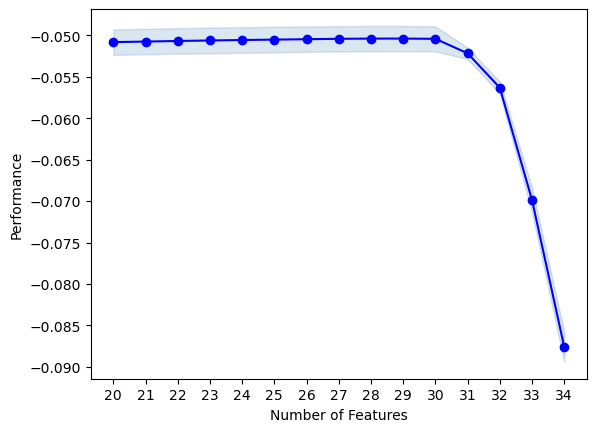

In [47]:
sfs_fit = sfs(svr_model, X_train, y_train, k_features=20, forward=False)

In [48]:
import mlflow

In [49]:
mlflow.end_run()

In [81]:
metric_dict = sfs_fit.get_metric_dict()

In [90]:
best_score = float('-inf')
best_k = 0
for key, val in metric_dict.items():
    if val['avg_score'] > best_score:
        best_k = key
        best_score = val['avg_score']

In [94]:
best_features = metric_dict[best_k]['feature_idx']

In [95]:
selected_features = [features[i] for i in best_features]

In [96]:
selected_features

['cc.SSF',
 'cc.TCF',
 'cc.WSF',
 'cc.SWS',
 'cc.SW_1',
 'cc.height_width_ratio',
 'cc.characters_to_cc_ratio',
 'morph.erosion',
 'morph.dilation',
 'morph.closing',
 'morph.opening',
 'noise.gaussian_1',
 'noise.gaussian_2',
 'noise.gaussian_3',
 'noise.gaussian_4',
 'noise.median_1',
 'noise.median_2',
 'spatial.foreground_percent',
 'spatial.gradients_1',
 'spatial.gradients_2',
 'spatial.gradients_3',
 'statistical.entropy_1',
 'statistical.entropy_2',
 'statistical.entropy_4',
 'statistical.entropy_5',
 'statistical.entropy_6',
 'statistical.entropy_7',
 'statistical.mean_sd_1',
 'statistical.grounds_mean_2']

In [101]:
X_train_sfs, X_test_sfs = X_train[:, best_features], X_test[:, best_features]

In [102]:
pipe_sfs = train_model(svr_model, X_train_sfs, y_train)

In [103]:
y_test, y_pred, results = evaluate_model(pipe_sfs, X_test_sfs, y_test)

In [104]:
results

{'R2': 0.7966534761731987,
 'MAE': 0.11021310300698738,
 'MSE': 0.027602432532349598,
 'PLCC': 0.8927326550023669,
 'SROCC': 0.7524640343744762}